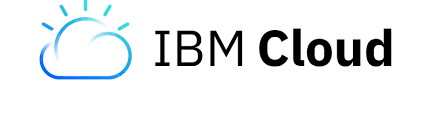
# CASE STUDY - convolutional neural networks

In [12]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import csv
import joblib
import time
from collections import Counter
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

plt.style.use('seaborn')
%matplotlib inline

Synopsis
----------

You were hired at AAVAIL to be a member of a data science team that works closely together.  Some of your first projects
are meant to help marketing with customer retention and to investigate market specific trends. There are also some
projects relating to user comments that are getting off the ground.  However, you will also be working alongside
the deep-learning specialists that maintain the core product at AAVAIL---its audio and visual manipulation models.

Because the team meets regularly all new data science hires are expected to go through a series deep-learning tutorials
to ensure that they can contribute to conversations about the core product.   The first in this series is the following
tutorial on CNNs.  You will be guided through the following parts.

  1. Environment setup
  2. Model scaffolding using Keras
  3. Logging and Model serialization
  4. Model iteration

## Fashion MNIST

>One project that the data science team at AAVAIL has been tasked with is ensuring that the video feeds are in fact news video feeds.  There are people that are performing quality assurance on these feeds, but eventually the data science team will need to build a service that samples a number of frames from a video, then identifies objects in the images, flagging for review any feeds that may be different.

A solid benchmark dataset for this task is the Fashion MNIST dataset.  

* training set - 60,000 images
* test set - 10,000 images
* images are 28 pixels x 28 pixels
* classes: T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot

## PART 1 - environment setup

In [13]:
## if you wish to work with tensorflow v1 then ask it to emulate version 2 behavior
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
print(tf.__version__)

## check hardware availability
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

1.14.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15710796851360275905
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 8711490919102620618
physical_device_desc: "device: XLA_CPU device"
]


In [14]:
### load the data  
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data() 
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 
               'Sneaker', 'Bag', 'Ankle boot']
num_classes = len(class_names)

## Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

X_train = train_images
X_test = test_images
y_train = train_labels
y_test = test_labels

### QUESTION 1

Visualize a sample of the images to QA the data set (for instance plot one image of each class). Then, print a summary of the data (for instance, the shape of training set, the shape of the test set, the number of sample per class...).

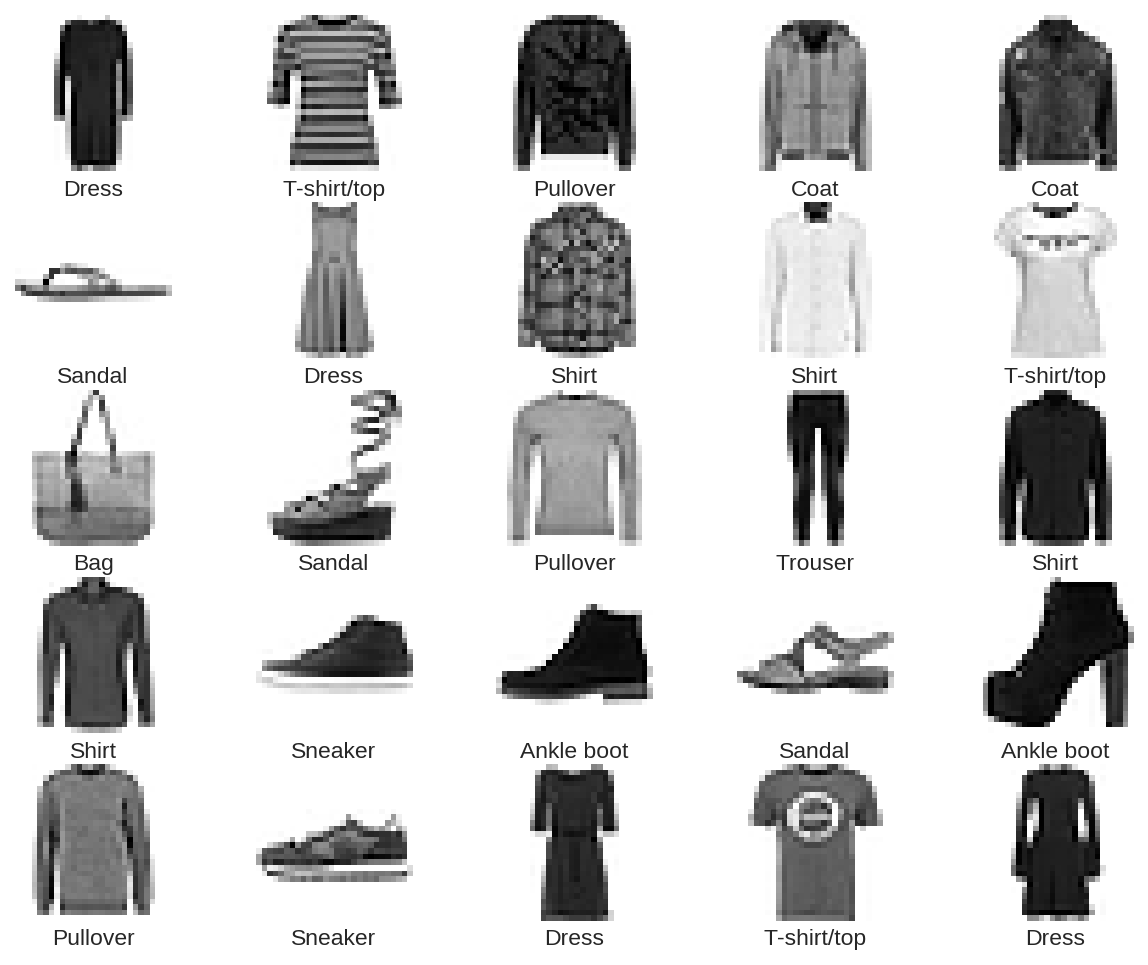

In [15]:
## YOUR CODE HERE (visualization code)

def show_img(img_ind):
    fig = plt.figure(figsize=(6,4),dpi=150,facecolor='white')
    ax = fig.add_subplot(111)

    ax.imshow(train_images[img_ind])
    ax.grid(False)
    ax.set_title(class_names[train_labels[img_ind]])
    
fig = plt.figure(figsize=(10,8),dpi=150,facecolor='white')
offset = 25
for i in range(25):
    ax = fig.add_subplot(5,5,i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)
    ax.imshow(train_images[i+offset], cmap=plt.cm.binary)
    ax.set_xlabel(class_names[train_labels[i+offset]])


In [16]:
## YOUR CODE HERE (Summarize the data)

print("-------------------------------------------")
print("X_train: {}".format(X_train.shape))
class_info = list(sorted(Counter(y_train).items()))
print("num classes: {}, classes: {}".format(len(class_info), [i[0] for i in class_info]))
print("class samples: {}".format([i[1] for i in class_info]))
print("class balance: {}".format([round(i[1]/X_train.shape[0],2) for i in class_info]))
print("-------------------------------------------")


-------------------------------------------
X_train: (60000, 28, 28)
num classes: 10, classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
class samples: [6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]
class balance: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
-------------------------------------------


Take a moment to understand how the data set is built, especially what are the 3 dimensions of X_train and X_test.

### QUESTION 2

In this question you are asked to build a base model. The base model that we want to build is composed of a PCA model followed by a classic machine learning classifier. The PCA takes as input the images that have been flattened and creates a representation of the images with few features (the first n principal components). Then, the classifier will classify the images based on this reduced representation. Following the best practices we will create a sklearn Pipeline. You are free to use the classifier that you think will perform best in this pipeline.

In [17]:
## YOUR CODE HERE (Replace the symbole #<> with your code)

# First we flatten the images to have a data shape that can be ingested by the PCA model.
# Take a moment to understand what does this function (flatten()) do to the images 
# and why this step is necessary.
X_train_flat = np.array([i.flatten() for i in train_images])
print(X_train_flat.shape)
X_test_flat = np.array([i.flatten() for i in test_images])
print(X_test_flat.shape)

(60000, 784)
(10000, 784)


# PCA and Random Forest

In [18]:


pipe = Pipeline([('pca', PCA(n_components=50)),
                 ('clf', RandomForestClassifier(n_estimators=100))])




In [19]:
if not os.path.isdir("saved"):
    os.mkdir("saved")

## we create a "saved" folder to save the trained model.
saved_model = os.path.join("saved",'pca-rf.joblib')
if not os.path.exists(saved_model):
    time_start = time.time()
    pipe.fit(X_train_flat, y_train)
    print("saving the pipeline")
    joblib.dump(pipe, saved_model)
    print("train time", time.strftime('%H:%M:%S', time.gmtime(time.time()-time_start)))
else:
    print("loading {} from file".format(saved_model))
    pipe = joblib.load(saved_model)
    

loading saved/pca-rf.joblib from file


In [20]:
## YOUR CODE HERE (Replace the symbole #<> with your code)
# Evaluate your model using the classification_report() function
y_pred = pipe.predict(X_test_flat)
print("-->".join(pipe.named_steps.keys()))
print(classification_report(y_test, y_pred, target_names=np.array(class_names)))


pca-->clf
              precision    recall  f1-score   support

 T-shirt/top       0.80      0.84      0.82      1000
     Trouser       1.00      0.96      0.98      1000
    Pullover       0.76      0.80      0.78      1000
       Dress       0.87      0.89      0.88      1000
        Coat       0.79      0.80      0.79      1000
      Sandal       0.92      0.92      0.92      1000
       Shirt       0.68      0.58      0.63      1000
     Sneaker       0.91      0.91      0.91      1000
         Bag       0.93      0.96      0.95      1000
  Ankle boot       0.92      0.94      0.93      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [21]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_pred)
print(confusion)

[[838   0  15  30   5   4  93   0  15   0]
 [  6 958   4  23   2   0   5   0   2   0]
 [ 15   0 798  14  98   0  68   0   7   0]
 [ 28   3   6 888  25   1  40   0   9   0]
 [  0   0 106  30 800   0  57   0   7   0]
 [  1   0   0   0   0 924   0  44   1  30]
 [155   0 122  31  86   1 580   0  25   0]
 [  0   0   0   0   0  34   0 914   1  51]
 [  1   0   5   7   3  13   9   3 957   2]
 [  0   0   0   0   0  23   0  38   1 938]]


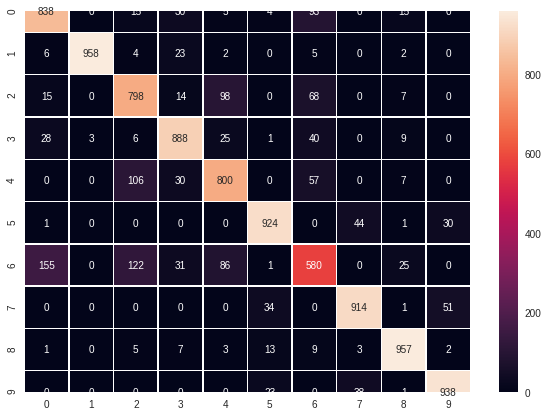

In [22]:
import seaborn as sns
plt.figure(figsize=(10,7))
sns.heatmap(confusion, annot=True, fmt="d" ,  linewidths=.5, )

# PCA and Grad Boosting clf

In [40]:
from sklearn.ensemble import GradientBoostingClassifier
pipe2 = Pipeline([('pca', PCA(n_components=100)),
                 ('clf', GradientBoostingClassifier(n_estimators=500 , learning_rate = 0.1))])




In [42]:
if not os.path.isdir("saved"):
    os.mkdir("saved")

## we create a "saved" folder to save the trained model.
saved_model = os.path.join("saved",'pca-gb.joblib')
if not os.path.exists(saved_model):
    time_start = time.time()
    pipe2.fit(X_train_flat, y_train)
    print("saving the pipeline")
    joblib.dump(pipe2, saved_model)
    print("train time", time.strftime('%H:%M:%S', time.gmtime(time.time()-time_start)))
else:
    print("loading {} from file".format(saved_model))
    pipe2 = joblib.load(saved_model)
    

loading saved/pca-gb.joblib from file


In [43]:
## YOUR CODE HERE (Replace the symbole #<> with your code)
# Evaluate your model using the classification_report() function
y_pred = pipe2.predict(X_test_flat)
print("-->".join(pipe2.named_steps.keys()))
print(classification_report(y_test, y_pred, target_names=np.array(class_names)))


pca-->clf
              precision    recall  f1-score   support

 T-shirt/top       0.80      0.86      0.83      1000
     Trouser       1.00      0.96      0.98      1000
    Pullover       0.76      0.80      0.78      1000
       Dress       0.87      0.88      0.88      1000
        Coat       0.77      0.80      0.79      1000
      Sandal       0.93      0.93      0.93      1000
       Shirt       0.72      0.59      0.65      1000
     Sneaker       0.92      0.92      0.92      1000
         Bag       0.94      0.96      0.95      1000
  Ankle boot       0.93      0.94      0.93      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [38]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_pred)
print(confusion)

[[856   0  17  32   6   5  69   0  15   0]
 [  6 958   4  24   4   0   2   0   2   0]
 [ 13   0 803  12 100   1  63   0   8   0]
 [ 28   3   9 884  35   0  35   0   6   0]
 [  2   0 104  31 799   1  57   0   6   0]
 [  0   0   0   1   0 930   0  37   4  28]
 [158   1 118  24  84   1 593   0  21   0]
 [  0   0   0   0   0  30   0 923   1  46]
 [  1   0   6   7   4  11   7   3 959   2]
 [  0   0   0   0   0  25   0  36   1 938]]


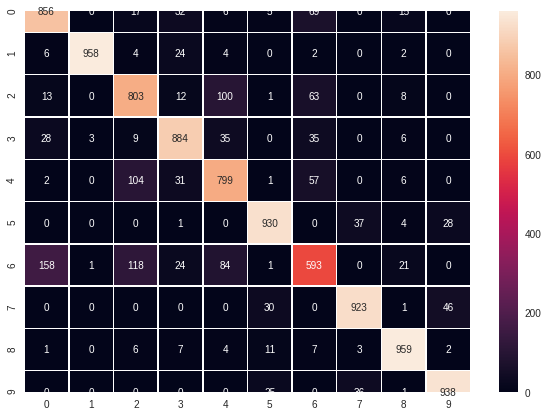

In [39]:
import seaborn as sns
plt.figure(figsize=(10,7))
sns.heatmap(confusion, annot=True, fmt="d" ,  linewidths=.5, )